In [1]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
from age_balance_analysis import channels, biomass, labelling
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


sns.set_style("darkgrid")

BIOMASS_DATA_PATH = Path("../data/2023_07_04_kirill_OD.csv")
LABELLING_DATA_PATH = Path("../data/2023_08_15_kirill_labelling.csv")


In [2]:
labelled_df = pd.read_csv(LABELLING_DATA_PATH)
labelled_df = labelled_df.rename(
    columns={
        "PG.ProteinAccessions": "gene",
        "HeavyFraction": "labelling",
        "Sum_F.Log10SignalToNoise_heavy": "s_over_n"
    }
)
s_over_n_threshold = labelled_df.s_over_n.median()
labelled_df = labelled_df[labelled_df.s_over_n > s_over_n_threshold]

## STEP 1: Fit the lysine pool based on the difference between the 1K and 2K channels

In [5]:
adjusted_df = labelled_df.pivot(index=["gene", "time", "condition"], columns="channel_number", values="labelling").reset_index()
c1_values = adjusted_df[1].values
c2_values = adjusted_df[2].values

FREE_AA_PSI = channels.find_best_fitting_psi(c1_values, c2_values)
adjusted_c1_values = channels.project_on_channel_one(c1_values, c2_values, FREE_AA_PSI)

# use the projected channel 1 results as the labelling data, and calculate the "unlabelled" fraction
adjusted_df["unlabelled_fraction"] = 1.0 - adjusted_c1_values

# average over repeats (if they exist) and create the DataFrame for fitting labelling curves 
unlabelled_df = adjusted_df.groupby(["gene", "time", "condition"]).mean(numeric_only=True).unlabelled_fraction.to_frame().reset_index()

In [6]:
fig1 = channels.plot_psi_fitting(c1_values, c2_values, FREE_AA_PSI)

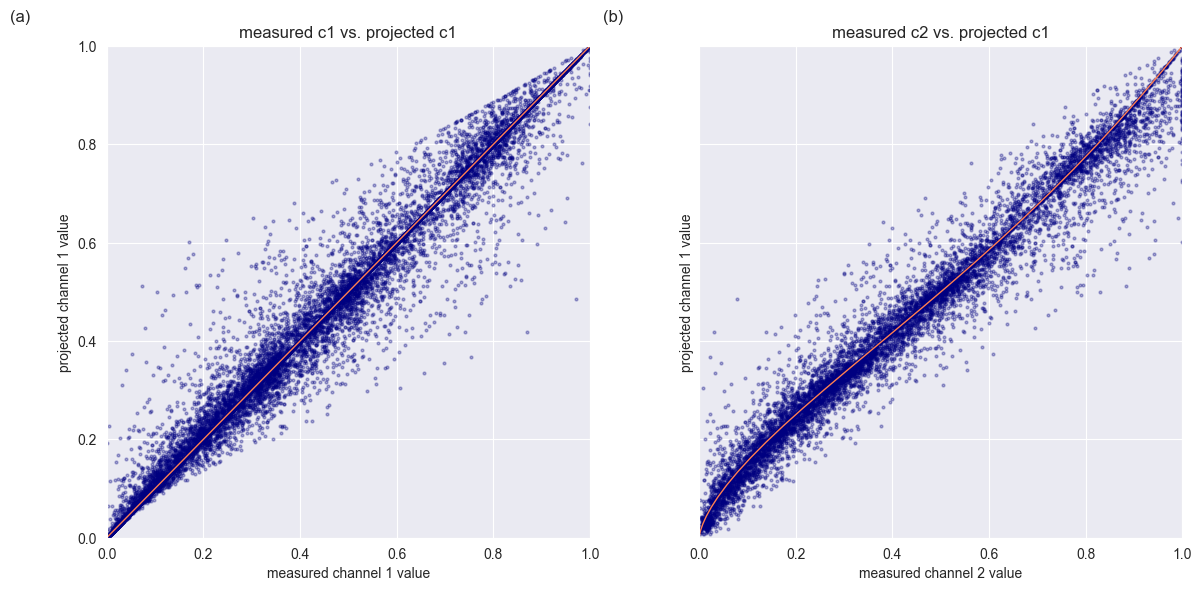

In [7]:
fig2 = channels.plot_projection(c1_values, c2_values, adjusted_c1_values, FREE_AA_PSI)

## STEP 2: calculate age distributions

The only two variables that we need to pass from step 1 are:
- `FREE_AA_PSI`
- `unlabelled_df`

condition:   30C
Growth rate:   μ = 5.57e-03 1/min
Doubling time: ln(2)/μ = 124.3 min
Average age (all biomass): 1/μ = 179.4 min
----------------------------------------
condition:   37C
Growth rate:   μ = 6.67e-03 1/min
Doubling time: ln(2)/μ = 103.9 min
Average age (all biomass): 1/μ = 149.9 min
----------------------------------------
condition:   FL
Growth rate:   μ = 4.01e-03 1/min
Doubling time: ln(2)/μ = 172.8 min
Average age (all biomass): 1/μ = 249.3 min
----------------------------------------
condition:   PD
Growth rate:   μ = 4.01e-03 1/min
Doubling time: ln(2)/μ = 172.8 min
Average age (all biomass): 1/μ = 249.3 min
----------------------------------------


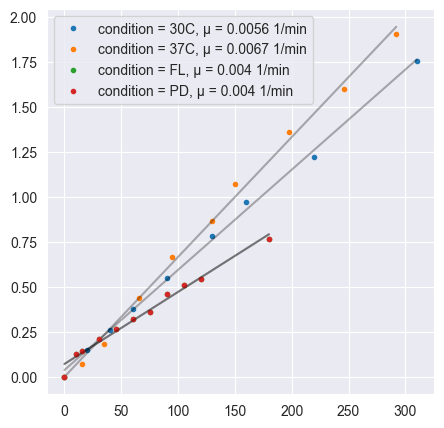

In [81]:
od_df = biomass.find_growth_rates(BIOMASS_DATA_PATH)

In [82]:
# instead of the "time" values, use the measured OD (in logscale) i.e. based on the relation:
# t = [ln(OD) - ln(OD_0)] / μ

time2od = od_df.set_index(["time", "condition"]).lnOD
_df = unlabelled_df.join(time2od, on=["time", "condition"])
_df = _df.pivot(index=["gene", "condition"], columns="lnOD", values="unlabelled_fraction")

ksm = labelling.KineticStateModel(initial_pool=FREE_AA_PSI, n_pools=2, measured_pool_index=1)
result_df, popt_dict, pcov_dict = ksm.fit_pools(_df)

100%|██████████| 6753/6753 [00:43<00:00, 155.90it/s]


In [83]:
print("Summary of error messages:")
result_df.groupby("error_message").count().iloc[:, 0]

Summary of error messages:


error_message
                                4871
not enough measured points      1881
overflow encountered in cosh       1
Name: index, dtype: int64

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
ax = axs[0]
ax.hist(result_df.mse, cumulative=True, bins=1000, histtype='step', density=True)
ax.set_xlabel("Fitting MSE")
ax.set_xlim(0, None)
ax.set_ylim(0, 1)
ax.set_ylabel("cumulative distribution")


ax = axs[1]
ax.hist(result_df.average_age, cumulative=True, bins=1000, histtype='step', density=True)
ax.set_xlabel("average age [units of 1/μ]")
ax.set_xlim(0, None)
ax.set_ylim(0, 1)
ax.set_ylabel("cumulative distribution")



Text(0, 0.5, 'cumulative distribution')

In [85]:
indices = [
    ("YBR106W", "30C"),
    ("YBR106W", "37C"),
    ("YDR168W", "30C"),
    ("YDR168W", "37C"),
]
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

xdata = _df.columns.to_numpy()
for ax, idx in zip(axs.flat, indices):
    ydata = _df.loc[idx, :].to_numpy()
    taus = popt_dict[idx]
    ksm.plot_fit(xdata, ydata, taus, ax, label=str(idx))
fig.tight_layout()